In [567]:
import pandas as pd
import numpy as np
import os
from sklearn.model_selection import train_test_split
from sklearn import metrics
import matplotlib.pyplot as plt

from load_dataset_title import get_dataset

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

from keras.callbacks import ModelCheckpoint,EarlyStopping

from gensim.models import KeyedVectors
from gensim.models import FastText as ft

from keras import layers, models, optimizers
from keras.regularizers import l2
from keras.models import Sequential
from keras.models import load_model
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import Embedding
from keras.layers import Conv1D,MaxPooling1D,Dropout,GlobalMaxPool1D,SpatialDropout1D,AveragePooling1D,GlobalAveragePooling1D
from keras.layers.normalization import BatchNormalization
import regex as re
from imblearn.over_sampling import RandomOverSampler
import random as random


cwd = os.getcwd()

In [4]:
#Min Jia suggested this...dunno why
def preprocess_text(sen):
    # Remove punctuations and numbers
    sentence = re.sub('[^a-zA-Z]', ' ', sen)

    # Single character removal
    sentence = re.sub(r"\s+[a-zA-Z]\s+", ' ', sentence)

    # Removing multiple spaces
    sentence = re.sub(r'\s+', ' ', sentence)

    return sentence

In [5]:
embed_model2 = ft.load_fasttext_format("cc.en.300.bin")

vec_dim = len(embed_model2["cat"])

c:\python 3.6.4\lib\site-packages\ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `load_fasttext_format` (use load_facebook_vectors (to use pretrained embeddings) or load_facebook_model (to continue training with the loaded full model, more RAM) instead).
  """Entry point for launching an IPython kernel.
c:\python 3.6.4\lib\site-packages\ipykernel_launcher.py:3: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  This is separate from the ipykernel package so we can avoid doing imports until


In [584]:
df = get_dataset(size = "large") #use small for small dataset, large for large dataset. Will print the number of articles loaded.
df_test = get_dataset(size = "small") #use small for small dataset, large for large dataset. Will print the number of articles loaded.

def generate_balanced_dataset_undersampling(df):
    only_nonclickbait = df.loc[df['label'] == "0"]
    only_clickbait = df.loc[df['label'] == "1"]

    while len(only_nonclickbait)!= len(only_clickbait):
        to_drop = random.randint(0, len(only_nonclickbait) - 1)
        only_nonclickbait = only_nonclickbait.drop(only_nonclickbait.index[to_drop])
        
    frames = [only_clickbait, only_nonclickbait]
    final_balanced_dataset = pd.concat(frames)
    print("Done generating balanced dataset via undersampling")
    return final_balanced_dataset
    
df_balanced = generate_balanced_dataset_undersampling(df)
df_balanced = df_balanced.sample(frac=1)
#percentage = 0.2

#Don't need this anymore, we are using the small dataset as our test set.
# (random_state): we use a fixed random seed so we get the same results every time.
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = percentage, random_state=51)


loading large document
19539
hi
loading small document
2460
hi
Done generating balanced dataset via undersampling


In [600]:
# X_train = df_balanced["title"]
# # X_train = X_train.apply(preprocess_text)
# y_train = df_balanced['label'].astype(int)

X_train = df["title"]
# #X_train = X_train.apply(preprocess_text)
y_train = df['label'].astype(int)

#Don't need this anymore, we are using the small dataset as our test set.
# (random_state): we use a fixed random seed so we get the same results every time.
X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size = percentage, random_state=51)

# X_test = df_test["title"]
# y_test = df_test["label"].astype(int)

In [570]:
# This cell is for oversampling
ros = RandomOverSampler(random_state=0)
X_train_resized = X_train.reshape(-1,1)
X_train, y_train = ros.fit_resample(X_train_resized, y_train)
X_train = X_train.flatten()

c:\python 3.6.4\lib\site-packages\ipykernel_launcher.py:3: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  This is separate from the ipykernel package so we can avoid doing imports until


In [601]:
#Finding length of longest title in training data

def get_max_length():
    t = Tokenizer()
    t.fit_on_texts(X_train)
    encoded_X = t.texts_to_sequences(X_train)
    max_length = 0
    for i in encoded_X:
        max_length = max(len(i), max_length)
    
    return max_length + 1

input_length = get_max_length()
print(input_length)

237


In [602]:
# # Outright setting length of longest title as 250
# input_length = 250
# print(input_length)

In [603]:
def pre_process_input(array):
    t = Tokenizer()
    t.fit_on_texts(array)
    vocab_size = len(t.word_index) + 1
    encoded_X = t.texts_to_sequences(array)

    ##input_length is a global variable
    padded_X = pad_sequences(encoded_X, maxlen = input_length,
                          padding = "post")
    
    return (padded_X, t)
    

In [604]:
#Create the padded X_test data as well as the padded X_train data
padded_X_train, t_train = pre_process_input(X_train)
vocab_size = len(t_train.word_index) + 1
input_length = len(padded_X_train[0])

padded_X_test = pre_process_input(X_test)[0]

In [605]:
#Create the embedding matrix using the training data,
embedding_matrix = np.zeros((vocab_size, vec_dim))
for word,i in t_train.word_index.items():
    embedding_vector = embed_model2[word]
    embedding_matrix[i] = embedding_vector
    

c:\python 3.6.4\lib\site-packages\ipykernel_launcher.py:4: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  after removing the cwd from sys.path.


## First model: Just logistic regression

In [606]:
#Hyper-Params
epochs = 10
batch_size = 32
patience = 3

#Define model
model1 = Sequential()
e = Embedding(vocab_size, vec_dim, weights = [embedding_matrix],
              input_length = input_length, trainable = False)
model1.add(e)
model1.add(Flatten())
model1.add(Dense(1, activation = "sigmoid"))

model1.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

### summarize the model
print(model1.summary())

### Create model checkpoint
output_dir = cwd
modelcheckpoint = ModelCheckpoint(filepath = output_dir + "/model1_titleweights.{epoch:02d}-{val_loss:.3f}.hdf5",
                                 monitor='val_loss', verbose=1, save_best_only=True)
callbacks_list = [modelcheckpoint, EarlyStopping(monitor = "val_loss", patience = patience)]

### fit the model
#model1.fit(padded_X_train, y_train, batch_size = batch_size, epochs=epochs, verbose=1, validation_split = 0.2, callbacks = callbacks_list)

callbacks_list_no_chkpt = [EarlyStopping(monitor = "val_loss", patience = 2)]

#fit with no checkpointing (oversampling)
#model1.fit(padded_X_train, y_train_resampled, batch_size = batch_size, epochs=epochs, verbose=1, validation_split = 0.1, callbacks = callbacks_list_no_chkpt)

#fit with no checkpointing
model1.fit(padded_X_train, y_train, batch_size = batch_size, epochs=epochs, verbose=1, validation_split = 0.15, callbacks = callbacks_list_no_chkpt)

Model: "sequential_80"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_80 (Embedding)     (None, 237, 300)          7441500   
_________________________________________________________________
flatten_40 (Flatten)         (None, 71100)             0         
_________________________________________________________________
dense_78 (Dense)             (None, 1)                 71101     
Total params: 7,512,601
Trainable params: 71,101
Non-trainable params: 7,441,500
_________________________________________________________________
None
Train on 13285 samples, validate on 2345 samples
Epoch 1/10
13285/13285 [==============================] - 3s 212us/step - loss: 0.5252 - accuracy: 0.7675 - val_loss: 0.4783 - val_accuracy: 0.7898
Epoch 2/10
13285/13285 [==============================] - 3s 205us/step - loss: 0.4758 - accuracy: 0.7866 - val_loss: 0.4674 - val_accuracy: 0.7910
Epoch 3/10
13285/1

In [607]:
### Evaluate the model
print(model1.metrics_names)
model1.evaluate(x=padded_X_test, y=y_test, verbose = 1)

['loss', 'accuracy']
3908/3908 [==============================] - 1s 141us/step


[0.5629777709134648, 0.7487205862998962]

In [608]:
#Printing confusion matrix for training data
y_train_pred = model1.predict(padded_X_train)
y_train_pred = np.array([1 if i > 0.5 else 0 for i in y_train_pred])
print("Confusion matrix for training data")
confusion_matrix_train = metrics.confusion_matrix(y_train, y_train_pred)
print(confusion_matrix_train)

#Printing confusion matrix for testing data
y_test_pred = model1.predict(padded_X_test)
y_test_pred = np.array([1 if i > 0.5 else 0 for i in y_test_pred])
print("Confusion matrix for testing data")
confusion_matrix_test = metrics.confusion_matrix(y_test,y_test_pred)
print(confusion_matrix_test)

Confusion matrix for training data
[[11334   454]
 [ 2333  1509]]
Confusion matrix for testing data
[[2863  126]
 [ 856   63]]


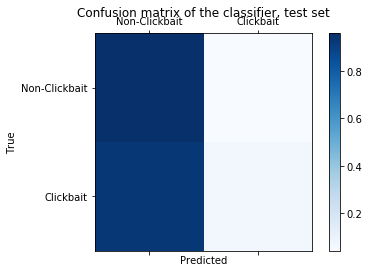

In [609]:
# Show confusion matrix in a separate window
def plot_cm(confusion_matrix):
    TN = confusion_matrix[0][0]
    TP = confusion_matrix[1][1]
    FP = confusion_matrix[0][1]
    FN = confusion_matrix[1][0]
    cm = [[0,0],[0,0]]
    cm[0][0] = TN / (TN + FP)
    cm[0][1] = FP / (TN + FP)
    cm[1][0] = FN / (FN + TP)
    cm[1][1] = TP / (FN + TP)
    
    labels = ['Non-Clickbait', 'Clickbait']
    fig = plt.figure()
    ax = fig.add_subplot(111)
    cax = ax.matshow(cm, cmap=plt.cm.Blues)
    plt.title('Confusion matrix of the classifier, test set')
    fig.colorbar(cax)
    ax.set_xticklabels([''] + labels)
    ax.set_yticklabels([''] + labels)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()
    
plot_cm(confusion_matrix_test)

## Second model: Coming soon!

## Third model: 1-D convnet

In [610]:
#Hyper-Params
epochs = 20 #50 orig
batch_size = 32 #for stochastic gradient descent
drop_embed = 0.3 #0.2 orig

n_dense = 256
dropout = 0.5 #0.5 orig

n_conv_layer1 = 16
n_conv_layer2 = 14
n_conv_layer3 = 12
n_conv_layer4 = 10
#n_conv_layer5 = 100
k_conv = 3

#Define model

model3 = Sequential()
e = Embedding(vocab_size, vec_dim, weights = [embedding_matrix],
              input_length = input_length, trainable = False)
model3.add(e)
model3.add(SpatialDropout1D(drop_embed))
model3.add(Conv1D(filters = n_conv_layer1, kernel_size = k_conv, activation = "relu", padding = "same"))
#model3.add(Conv1D(filters = n_conv_layer1, kernel_size = k_conv, activation = "relu", padding = "same"))
model3.add(MaxPooling1D(2))
# model3.add(Conv1D(filters = n_conv_layer2, kernel_size = k_conv, activation = "relu", padding = "same"))
# model3.add(Conv1D(filters = n_conv_layer2, kernel_size = k_conv, activation = "relu", padding = "same"))
# model3.add(MaxPooling1D(2))
# model3.add(Conv1D(filters = n_conv_layer3, kernel_size = k_conv, activation = "relu", padding = "same"))
model3.add(Conv1D(filters = n_conv_layer3, kernel_size = k_conv, activation = "relu", padding = "same"))
model3.add(MaxPooling1D(2))
# model3.add(Conv1D(filters = n_conv_layer4, kernel_size = k_conv, activation = "relu", padding = "same"))
model3.add(Conv1D(filters = n_conv_layer4, kernel_size = k_conv, activation = "relu", padding = "same"))
model3.add(GlobalMaxPool1D())
model3.add(Dropout(dropout))
model3.add(Dense(1, activation = "sigmoid"))
model3.compile(optimizer='adam',
              loss='binary_crossentropy',
#              loss = "mean_squared_error",
              metrics=['accuracy'])

### summarize the model
print(model3.summary())

### Create model checkpoint
output_dir = cwd
modelcheckpoint = ModelCheckpoint(filepath = output_dir + "/model3_titleweights_oversamp.{epoch:02d}-{val_loss:.3f}.hdf5",
                                 monitor='val_loss', verbose=1, save_best_only=True)
callbacks_list = [modelcheckpoint, EarlyStopping(monitor = "val_loss", patience = 4)]

callbacks_list_no_chkpt = [EarlyStopping(monitor = "val_loss", patience = 2)]

### fit the model
model3.fit(padded_X_train, y_train, batch_size = batch_size, epochs=epochs, verbose=1, validation_split = 0.15, callbacks = callbacks_list)

#fit with no checkpointing
#model3.fit(padded_X_train, y_train, batch_size = batch_size, epochs=epochs, verbose=1, validation_split = 0.1, callbacks = callbacks_list_no_chkpt)

Model: "sequential_81"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_81 (Embedding)     (None, 237, 300)          7441500   
_________________________________________________________________
spatial_dropout1d_41 (Spatia (None, 237, 300)          0         
_________________________________________________________________
conv1d_222 (Conv1D)          (None, 237, 16)           14416     
_________________________________________________________________
max_pooling1d_102 (MaxPoolin (None, 118, 16)           0         
_________________________________________________________________
conv1d_223 (Conv1D)          (None, 118, 12)           588       
_________________________________________________________________
max_pooling1d_103 (MaxPoolin (None, 59, 12)            0         
_________________________________________________________________
conv1d_224 (Conv1D)          (None, 59, 10)          

In [611]:
### Evaluate the best model
#model3_loaded = load_model("model3_titleweights.03-0.462.hdf5") #this is with pre-processing
#model3_loaded = load_model("model3_titleweights_resamp.17-0.032.hdf5")  #This is with random oversampling
#model3_loaded = load_model("model3_titleweights_undersamp.03-0.594.hdf5") #this is with undersampling. padding length = 250
#model3_loaded = load_model("model3_titleweights.03-0.478.hdf5") #another without pre-processing, gives better results than first one
# model3_loaded = load_model("model3_titleweights.04-0.588.hdf5") #With undersampling. Padding length = 237

model3_loaded = load_model("model3_titleweights_oversamp.07-0.449.hdf5")
#model3_loaded = model3
print(model3_loaded.metrics_names)
model3_loaded.evaluate(x=padded_X_test, y=y_test, verbose = 1)

['loss', 'accuracy']
3908/3908 [==============================] - 1s 239us/step


[0.5467254566133571, 0.7592118978500366]

In [612]:
#Printing confusion matrix for training data
y_train_pred = model3_loaded.predict(padded_X_train)
y_train_pred = np.array([1 if i > 0.5 else 0 for i in y_train_pred])
print("Confusion matrix for training data")
confusion_matrix_train = metrics.confusion_matrix(y_train, y_train_pred)
print(confusion_matrix_train)

#Printing confusion matrix for training data
y_test_pred = model3_loaded.predict(padded_X_test)
y_test_pred = np.array([1 if i > 0.5 else 0 for i in y_test_pred])
print("Confusion matrix for testing data")
confusion_matrix_test = metrics.confusion_matrix(y_test, y_test_pred)
print(confusion_matrix_test)

Confusion matrix for training data
[[11423   365]
 [ 2626  1216]]
Confusion matrix for testing data
[[2913   76]
 [ 865   54]]


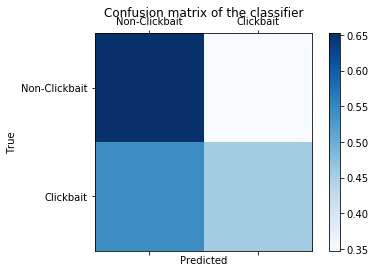

In [598]:
# Show confusion matrix in a separate window
def plot_cm(confusion_matrix):
    TN = confusion_matrix[0][0]
    TP = confusion_matrix[1][1]
    FP = confusion_matrix[0][1]
    FN = confusion_matrix[1][0]
    cm = [[0,0],[0,0]]
    cm[0][0] = TN / (TN + FP)
    cm[0][1] = FP / (TN + FP)
    cm[1][0] = FN / (FN + TP)
    cm[1][1] = TP / (FN + TP)
    
    labels = ['Non-Clickbait', 'Clickbait']
    fig = plt.figure()
    ax = fig.add_subplot(111)
    cax = ax.matshow(cm, cmap=plt.cm.Blues)
    plt.title('Confusion matrix of the classifier')
    fig.colorbar(cax)
    ax.set_xticklabels([''] + labels)
    ax.set_yticklabels([''] + labels)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()
    
plot_cm(confusion_matrix_test)

In [599]:
#get the balanced accuracy score
def get_balanced_accuracy(confusion_matrix):
    TN = confusion_matrix[0][0]
    TP = confusion_matrix[1][1]
    FP = confusion_matrix[0][1]
    FN = confusion_matrix[1][0]
    TPR = TP / (TP + FN)
    TNR = TN/(TN + FP)
    return 0.5 * (TPR + TNR)

print(get_balanced_accuracy(confusion_matrix_train))
print(get_balanced_accuracy(confusion_matrix_test))
    

0.7804292169681873
0.5545537240200673
